---
# Collocation Method for Harmonic Oscillator

The harmonic oscillator system of first-order differential equations:

$$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$$

with initial conditions:

$$
x_1(0) = x_{1,0}, \quad x_2(0) = x_{2,0}
$$

can be discretized using the collocation method as follows.

---
## Discretization and Approximation

Choose $N$ collocation points $t_1, t_2, \ldots, t_N$ in $[0, T]$.

Approximate $x_1(t)$ and $x_2(t)$ by:

$$
x_1(t) \approx p_1(t) = \sum_{j=0}^{N} c_{1,j} \phi_j(t)
$$

$$
x_2(t) \approx p_2(t) = \sum_{j=0}^{N} c_{2,j} \phi_j(t)
$$


---
## Collocation Conditions

Recalling 
$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$

At each collocation point $t_i$, we can obtain:

$$
\sum_{j=0}^{N} c_{1,j} \frac{d \phi_j(t_i)}{dt} = \sum_{j=0}^{N} c_{2,j} \phi_j(t_i)
$$

$$
\sum_{j=0}^{N} c_{2,j} \frac{d \phi_j(t_i)}{dt} = -\omega^2 \sum_{j=0}^{N} c_{1,j} \phi_j(t_i)
$$


---
## Initial Conditions

To solve for the coefficients $c_{1,j}$ and $c_{2,j}$:

$$
\sum_{j=0}^{N} c_{1,j} \phi_j(0) = x_{1,0}
$$

$$
\sum_{j=0}^{N} c_{2,j} \phi_j(0) = x_{2,0}
$$
---

In [314]:
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt

from interpolation import BarycentricInterpolation
from collocation import lagrange_basis, lagrange_derivative, lagrange_basis_node, compute_weights

#### Define the number of collocation points and the time interval

In [315]:
N = 10
omega = 5.0 # Angular frequency of the harmonic oscillator

T = 2
interpolator = BarycentricInterpolation(N, start = 0, stop = T)

collocation_points = interpolator.nodes

collocation_points

array([0.        , 0.06030738, 0.23395556, 0.5       , 0.82635182,
       1.17364818, 1.5       , 1.76604444, 1.93969262, 2.        ])

### Discretization and Collocation

In [316]:
phi = lagrange_basis_node(collocation_points)

weights = compute_weights(collocation_points)

dphi_dt = lagrange_derivative(collocation_points, weights)

### Initial Conditions

In [317]:
# Initial conditions
x1_0 = 1.0
x2_0 = 0.0

### Collocation Conditions

`CC.1` We approximate $ x_1(t) $ and $ x_2(t) $ using basis functions $ \phi_j(t) $

$$
x_1(t) \approx p_1(t) = \sum_{j=0}^{N} c_{1,j} \phi_j(t)
$$

$$
x_2(t) \approx p_2(t) = \sum_{j=0}^{N} c_{2,j} \phi_j(t)
$$

`CC.2` At each collocation point $ t_i $:

1. Following $ \frac{dx_1}{dt} = x_2 $, we obtain:
$$
\sum_{j=0}^{N} c_{1,j} \frac{d \phi_j(t_i)}{dt} = \sum_{j=0}^{N} c_{2,j} \phi_j(t_i)
$$

2. Following $ \frac{dx_2}{dt} = -\omega^2 x_1 $, we obtain:
$$
\sum_{j=0}^{N} c_{2,j} \frac{d \phi_j(t_i)}{dt} = -\omega^2 \sum_{j=0}^{N} c_{1,j} \phi_j(t_i)
$$


`CC.3` Matrix Representation

To form a system of equations, we organize the terms involving the coefficients $ c_{1,j} $ and $ c_{2,j} $ into matrix form.

- Let $ dphi\_dt $ be the matrix of the derivatives of the basis functions evaluated at the collocation points.
- Let $ phi $ be the matrix of the basis functions evaluated at the collocation points.
$$

---
For the `first collocation condition` $ \frac{dx_1}{dt} = x_2 $:

$$
dphi\_dt \cdot \mathbf{c_1} = phi \cdot \mathbf{c_2}
$$

This can be written in block matrix form as:
$$
[dphi\_dt \quad -phi] \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{0}
$$

---
For `the second collocation condition` $ \frac{dx_2}{dt} = -\omega^2 x_1 $:

$$
dphi\_dt \cdot \mathbf{c_2} = -\omega^2 \cdot phi \cdot \mathbf{c_1}
$$

This can be written in block matrix form as:
$$
[\omega^2 \cdot phi \quad dphi\_dt] \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{0}
$$
---

`CC.4` Constructing the Matrix $ A $

Combining these two sets of equations, we form the block matrix $ A $:

$$
A = \begin{bmatrix}
dphi\_dt & -phi \\
\omega^2 \cdot phi & dphi\_dt
\end{bmatrix}
$$

`CC.5`
The complete linear system we need to solve is:

$$
A \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{b},
$$

where $b$ is **0** for each `collocation condition` part.


In [318]:
A = jnp.block([
    [dphi_dt, -phi],
    [omega**2 * phi, dphi_dt]
])

A.shape

(20, 20)

The shape is $N$ x $N$

`CC.6` Initial Conditions + Collocation Conditions

* The initial + collocation conditions are represented by vector *b*
* The full shape is expected to be $(N + 1) * 2$ 

Initial Conditions Matrix:

$$
I_{x1} = \begin{bmatrix} 
\phi_j(0) 
\end{bmatrix}_{j=0}^{N} \quad \text{and zeros for } c_{2,j}
$$

$$
I_{x2} = \text{zeros for } c_{1,j} \quad \begin{bmatrix} 
\phi_j(0) 
\end{bmatrix}_{j=0}^{N}
$$


Right-Hand Side Vector $b_{\text{aug}}$:

$$
b_{\text{aug}} = \begin{bmatrix} 
0 \\ 
\vdots \\ 
0 \\ 
x_{1,0} \\ 
x_{2,0} 
\end{bmatrix}
$$

In [319]:
b = jnp.zeros(2 * (N))

b_aug = jnp.concatenate([b, jnp.array([x1_0, x2_0])])

b_aug.shape

b_aug

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.], dtype=float32)

Augmented Matrix $A_{\text{aug}}$:

$$
A_{\text{aug}} = \begin{bmatrix} 
A \\ 
I_{x1} \\ 
I_{x2} 
\end{bmatrix}
$$

In [320]:
I_x1 = jnp.zeros((1, 2 * (N)))
I_x1 = I_x1.at[0, :N].set(phi[0, :])

I_x2 = jnp.zeros((1, 2 * (N)))
I_x2 = I_x2.at[0, N:].set(phi[0, :])

# Augment A with initial conditions
A_aug = jnp.vstack([A, I_x1, I_x2])

A_aug.shape

(22, 20)

`CC.7` Solve

The original system is given by:

$$ A c = b $$

To solve this system using the normal equations, we transform it into:

$$ A^T A c = A^T b $$

In [321]:
# Solve the linear system for the coefficients
c = solve(A_aug.T @ A_aug, A_aug.T @ b_aug)

`CC.8` Extract Coefficients

In [322]:
# Extract the coefficients for x1 and x2
c1 = c[:N]
c2 = c[N:2*(N)]

# print(c1.shape)
print("C1:\n", c1)
print("C2:\n", c2)

C1:
 [ 0.93230087  0.89302677  0.36331296 -0.7544368  -0.48718932  0.81301093
  0.34660926 -0.75231147 -0.8918316  -0.7811125 ]
C2:
 [-2.9046694e-03 -1.3872789e+00 -4.3171334e+00 -2.7357390e+00
  3.8106930e+00  1.8926392e+00 -4.2381058e+00 -2.6784689e+00
  1.1471013e+00  2.4158025e+00]


In [323]:
display(lagrange_basis)

<function collocation.lagrange_basis(xi, x)>

In [324]:
def lagrange_basis_(j, t, points):
    terms = [(t - points[m]) / (points[j] - points[m]) for m in range(len(points)) if m != j]
    return jnp.prod(jnp.array(terms))

# Define the matrix of basis functions evaluated at test points
def lagrange_basis_matrix(points, t_test):
    N = len(points) - 1
    return jnp.array([[lagrange_basis_(j, t, points) for j in range(N + 1)] for t in t_test])

In [325]:
t_test = jnp.linspace(0, T, 100)
lb = lagrange_basis_matrix(collocation_points, t_test)

x1_test = lb @ c1
x2_test = lb @ c2

x1_test shape: (100,)
x2_test shape: (100,)


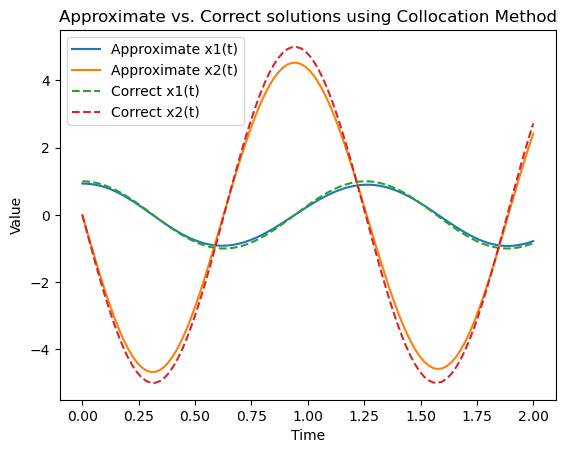

In [326]:
import matplotlib.pyplot as plt

x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

# Display the results
print("x1_test shape:", x1_test.shape)
print("x2_test shape:", x2_test.shape)

# Plot the results
plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.show()

### Complete Script

In [327]:
# Parameters
N = 20
omega = 2.0 
T = 10

interpolator = BarycentricInterpolation(N, start=0, stop=T)
collocation_points = interpolator.nodes

phi = lagrange_basis_node(collocation_points)
weights = compute_weights(collocation_points)
dphi_dt = lagrange_derivative(collocation_points, weights)

x1_0 = 1.0
x2_0 = 0.0

# Form the collocation matrix A
A = jnp.block([
    [dphi_dt, -phi],       # First collocation condition: dx1/dt = x2
    [omega**2 * phi, dphi_dt]  # Second collocation condition: dx2/dt = -omega^2 * x1
])

b = jnp.zeros(2 * (N))
b_aug = jnp.concatenate([b, jnp.array([x1_0, x2_0])])

I_x1 = jnp.zeros((1, 2 * (N)))
I_x1 = I_x1.at[0, :N].set(phi[0, :])

I_x2 = jnp.zeros((1, 2 * (N)))
I_x2 = I_x2.at[0, N:].set(phi[0, :])

A_aug = jnp.vstack([A, I_x1, I_x2])

# Solve the linear system using the normal equations
# A^T A c = A^T b
c = solve(A_aug.T @ A_aug, A_aug.T @ b_aug)

c1 = c[:N]
c2 = c[N:]

In [329]:
lagrange_basis(collocation_points, t_test)

TypeError: lagrange_basis() missing 1 required positional argument: 'points'

In [328]:
# Test the approximations
t_test = jnp.linspace(0, T, 100)
lb = jnp.transpose(lagrange_basis(collocation_points, t_test))

x1_test = lb @ c1
x2_test = lb @ c2

# Compute the correct solutions
x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.grid(True)
plt.show()

TypeError: lagrange_basis() missing 1 required positional argument: 'points'

### Can it be also solved as an optimization problem?

In [313]:
from jax.scipy.optimize import minimize

In [312]:
# Objective function for optimization
def objective(c, A, b):
    residuals = A @ c - b
    return jnp.sum(residuals**2)

# Initial guess for c
initial_c = jnp.zeros(A_aug.shape[1])

# Solve the optimization problem
result = minimize(objective, initial_c, args=(A_aug, b_aug), method='BFGS')
c_opt = result.x

# Display the result
print("Optimal solution vector c:", c_opt)
print("Shape of c:", c_opt.shape)

# Extract coefficients
c1 = c_opt[:N+1]
c2 = c_opt[N+1:]

# Define the Lagrange basis function for a single point
def lagrange_basis(j, t, points):
    terms = [(t - points[m]) / (points[j] - points[m]) for m in range(len(points)) if m != j]
    return jnp.prod(jnp.array(terms))

# Define the matrix of basis functions evaluated at test points
def lagrange_basis_matrix(points, t_test):
    N = len(points) - 1
    return jnp.array([[lagrange_basis(j, t, points) for j in range(N + 1)] for t in t_test])

# Test the approximations
t_test = jnp.linspace(0, T, 100)
lb = lagrange_basis_matrix(collocation_points, t_test)

x1_test = lb @ c1
x2_test = lb @ c2

# Compute the correct solutions
x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

# Display the results
print("x1_test shape:", x1_test.shape)
print("x2_test shape:", x2_test.shape)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.show()


ValueError: Incompatible shapes for broadcasting: (5,) and requested shape (6,)

In [8]:
# Coefficients of the collocation equation
C = np.zeros((degree+1, degree+1))
D = np.zeros(degree+1)
B = np.zeros(degree+1)

In [3]:
# Construct polynomial basis
for j in range(degree+1):
    # Construct the Lagrange polynomial
    L = np.poly1d([1])
    for r in range(degree+1):
        if r != j:
            L *= np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    Ldot = np.polyder(L)
    for r in range(degree+1):
        C[j, r] = Ldot(tau_root[r])
    integral_L = np.polyint(L)
    B[j] = integral_L(1.0)

# Time points
h = T / N
t = np.linspace(0, T, N+1)

# Declare variables
X1 = MX.sym('X1', N+1)
X2 = MX.sym('X2', N+1)
U = MX.sym('U', N)

# Collocation variables
X1c = [MX.sym(f'X1c_{j}') for j in range(degree)]
X2c = [MX.sym(f'X2c_{j}') for j in range(degree)]

# Initial conditions
x1_0 = 2.0
x2_0 = 0.0

# System dynamics
def f(x1, x2, u):
    return vertcat(x2, mu * (1 - x1**2) * x2 - x1)

# Create the collocation equations
g = []
g.append(X1[0] - x1_0)
g.append(X2[0] - x2_0)

for k in range(N):
    X1k_end = D[0] * X1[k]
    X2k_end = D[0] * X2[k]
    for j in range(1, degree+1):
        xp1 = C[0, j] * X1[k]
        xp2 = C[0, j] * X2[k]
        for r in range(1, degree+1):
            xp1 += C[r, j] * X1c[r-1]
            xp2 += C[r, j] * X2c[r-1]
        [fk1, fk2] = f(X1c[j-1], X2c[j-1], U[k])
        g.append(h * fk1 - xp1)
        g.append(h * fk2 - xp2)
        X1k_end += D[j] * X1c[j-1]
        X2k_end += D[j] * X2c[j-1]
    g.append(X1[k+1] - X1k_end)
    g.append(X2[k+1] - X2k_end)

g = vertcat(*g)

# Create NLP
w = vertcat(X1, X2, U, vertcat(*X1c), vertcat(*X2c))
nlp = {'x': w, 'f': dot(U, U), 'g': g}
solver = nlpsol('solver', 'ipopt', nlp)

# Initial guess
w0 = np.zeros((N+1)*2 + N + degree*2)

# Solve NLP
sol = solver(x0=w0, lbg=0, ubg=0)

# Extract solution
X1_opt = np.array(sol['x'][0:N+1])
X2_opt = np.array(sol['x'][N+1:2*(N+1)])
U_opt = np.array(sol['x'][2*(N+1):2*(N+1)+N])

# Plot results
plt.figure()
plt.plot(t, X1_opt, label='x1')
plt.plot(t, X2_opt, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.show()


Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define parameters
mu = 1.0
T = 10  # Total time
N = 100  # Number of discretization points
degree = 3  # Degree of the polynomial

# Collocation points
tau_root = np.append(0, np.polynomial.legendre.leggauss(degree)[0])

# Coefficients of the collocation equation
C = np.zeros((degree+1, degree+1))
D = np.zeros(degree+1)
B = np.zeros(degree+1)

# Construct polynomial basis
for j in range(degree+1):
    # Construct the Lagrange polynomial
    L = np.poly1d([1])
    for r in range(degree+1):
        if r != j:
            L *= np.poly1d([1, -tau_root[r]]) / (tau_root[j] - tau_root[r])
    D[j] = L(1.0)
    Ldot = np.polyder(L)
    for r in range(degree+1):
        C[j, r] = Ldot(tau_root[r])
    integral_L = np.polyint(L)
    B[j] = integral_L(1.0)

# Time points
h = T / N
t = np.linspace(0, T, N+1)

# Initial conditions
x1_0 = 2.0
x2_0 = 0.0

# System dynamics
def f(x1, x2, u):
    return jnp.array([x2, mu * (1 - x1**2) * x2 - x1])

# Objective function to minimize
def objective(vars):
    U = vars[:N]
    X1 = vars[N:N+N+1]
    X2 = vars[N+N+1:]
    
    cost = jnp.sum(U**2)
    return cost

# Constraints
def constraints(vars):
    U = vars[:N]
    X1 = vars[N:N+N+1]
    X2 = vars[N+N+1:]
    
    g = []
    g.append(X1[0] - x1_0)
    g.append(X2[0] - x2_0)
    
    for k in range(N):
        X1k_end = D[0] * X1[k]
        X2k_end = D[0] * X2[k]
        for j in range(1, degree+1):
            xp1 = C[0, j] * X1[k]
            xp2 = C[0, j] * X2[k]
            for r in range(1, degree+1):
                xp1 += C[r, j] * vars[N+N+1 + r-1]
                xp2 += C[r, j] * vars[N+N+1 + r-1]
            fk = f(vars[N+N+1 + j-1], vars[N+N+1 + j-1], U[k])
            g.append(h * fk[0] - xp1)
            g.append(h * fk[1] - xp2)
            X1k_end += D[j] * vars[N+N+1 + j-1]
            X2k_end += D[j] * vars[N+N+1 + j-1]
        g.append(X1[k+1] - X1k_end)
        g.append(X2[k+1] - X2k_end)
    
    return jnp.array(g)

# Initial guess
vars0 = np.zeros(2*(N+1) + N)

# Solve the problem using SciPy's minimize function
solution = minimize(objective, vars0, constraints={'type': 'eq', 'fun': constraints}, method='SLSQP')

# Extract solution
vars_opt = solution.x
U_opt = vars_opt[:N]
X1_opt = vars_opt[N:N+N+1]
X2_opt = vars_opt[N+N+1:]

# Plot results
plt.figure()
plt.plot(t, X1_opt, label='x1')
plt.plot(t, X2_opt, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.show()


/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:1374: RuntimeWarning: divide by zero encountered in divide
  return poly1d(self.coeffs/other)
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:1374: RuntimeWarning: invalid value encountered in divide
  return poly1d(self.coeffs/other)
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


ValueError: negative dimensions are not allowed